In [50]:
from langgraph.graph import StateGraph, START, END
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import TypedDict, Literal, Dict
from langchain_core.prompts import PromptTemplate
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import tabula
import os 

In [51]:
#Loading .env file
load_dotenv()

True

In [52]:
# Groq related Global variables
groq_api_key=os.getenv("Groq_API_Key")
groq_temperature=os.getenv("Groq_Temperature")
groq_model_name=os.getenv("Groq_Model_Name")

# Ollama related Global variables
ollama_embedding_model_name=os.getenv("Ollama_Embedding_Model_Name")
ollama_model_temperature=os.getenv("Ollama_Embedding_Model_Temperature")

# printing the values
# print("Groq api keys : ",groq_api_key)
# print("Groq temperature : ",groq_temperature)
# print("Groq_model_name : ",groq_model_name)

# print("Ollama model name : ",ollama_embedding_model_name)
# print("Ollama model temperature : ",ollama_model_temperature)

In [53]:
# Pydantic Class
class LLM_Structured_Output(BaseModel):
    answer:str=Field("This key contain the answer provided by the llm based on the provided context.")
    confidence:int=Field("This key contain how much confidence llm have on the provided output.")
    risk_level:Literal["Low","Medium","High"]=Field("This key contain the risk in the provided answer for taking decision.")
    decision:Literal["Show answer","Show Warning","Block Answer","Ask user to rephrase."]=Field("This key is for the decision of the LLM for showing, warning, blocking and rephrasing the the answer.")
    warning_message:str=Field("This key contain the warning given by the model if there is not any warnong then put 'None' in it.")

In [54]:
# creating the state 
class ai_monitoring_state(TypedDict):
    query:str
    context:str
    PDFFile_path:str
    texual_loaded_data:str
    tabular_loaded_data:str
    image_loaded_data:str
    texual_splitted_data:str
    tabular_splitted_data:str
    image_splitted_data:str
    ollama_embedding_model:any
    texual_vs:any
    texual_retriever_context:str
    llm_answer:Dict
    sources:str

In [55]:
parser = PydanticOutputParser(
    pydantic_object=LLM_Structured_Output
)

print("This is parser : ",parser)

This is parser :  pydantic_object=<class '__main__.LLM_Structured_Output'>


In [56]:
# LLM model getting here 
model=ChatGroq(model=groq_model_name,temperature=groq_temperature)
print("This is model : ",model)

This is model :  profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True} client=<groq.resources.chat.completions.Completions object at 0x000002E8F7A23F90> async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002E8F7A22110> model_name='openai/gpt-oss-120b' temperature=0.4 model_kwargs={} groq_api_key=SecretStr('**********')


In [57]:
query="What are the seven wonders in the india?"
prompt = PromptTemplate(
    template="""
        You must answer ONLY in valid JSON.
        Do not add explanation or text outside JSON.

        {format_instructions}

        Question:
        {query}
    """,
    input_variables=["query"],
    partial_variables={
        "format_instructions": parser.get_format_instructions()
    }
)


In [58]:
chain=prompt|model|parser

In [59]:
output=chain.invoke({"query":query})

In [60]:
print(output.answer)
print(output.confidence)
print(output.risk_level)
print(output.decision)
print(output.warning_message)

The commonly cited Seven Wonders of India are:
1. Taj Mahal (Agra)
2. Hampi (Karnataka)
3. Qutub Minar (Delhi)
4. Khajuraho Group of Monuments (Madhya Pradesh)
5. Konark Sun Temple (Odisha)
6. Elephanta Caves (Maharashtra)
7. Charminar (Hyderabad)
8
Low
Show answer
None


In [61]:
# Creating the Document Loader node
def Texual_Data_Loader(state:ai_monitoring_state):
    texual_loader=PyPDFLoader(file_path=state["PDFFile_path"])
    texual_loaded_data=texual_loader.load()
    return {"texual_loaded_data":texual_loaded_data}

def Tabular_Data_Loader(state:ai_monitoring_state):
    tfs = tabula.read_pdf(
        state["PDFFile_path"],
        pages="all"
    )
    if tfs:
        return {'tabular_loaded_data':tfs[0]}
    else:
        return {'tabular_loaded_data':'none'}

In [62]:
# Creating the text splitter node
def Textual_Data_Splitter(state: ai_monitoring_state):
    textual_data = state["texual_loaded_data"]
    splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
    texts = splitter.split_documents(textual_data)
    return {"texual_splitted_data": texts}

In [63]:
# Node for Embedding of the texual document
def Texual_Data_Embedding(state: ai_monitoring_state):
    emb=OllamaEmbeddings(model=ollama_embedding_model_name)
    return {"ollama_embedding_model":emb}

In [64]:
# Node for texual data in the vectorstoring 
def Texual_VectorStore(state: ai_monitoring_state):
    tvs=FAISS.from_documents(state['texual_splitted_data'],state['ollama_embedding_model'])
    return {'texual_vs':tvs}

In [65]:
# node for the texual data retriever
def Texual_VectorStoreRetriever(state:ai_monitoring_state):
    vs=state["texual_vs"]
    retriever=vs.as_retriever(search_type="mmr", search_kwargs={"k": 6, "lambda_mult": 0.25})
    out=retriever.invoke(state['query'])
    return {'texual_retriever_context':out}

In [ ]:
#

In [72]:
graph=StateGraph(ai_monitoring_state)

In [73]:
graph.add_node("Texual_Data_Loader",Texual_Data_Loader)
graph.add_node("Textual_Data_Splitter",Textual_Data_Splitter)
graph.add_node("Texual_Data_Embedding",Texual_Data_Embedding)
graph.add_node("Texual_VectorStore",Texual_VectorStore)
graph.add_node("Texual_VectorStoreRetriever",Texual_VectorStoreRetriever)

In [74]:
graph.add_edge(START,"Texual_Data_Loader")
graph.add_edge("Texual_Data_Loader","Textual_Data_Splitter")
graph.add_edge("Textual_Data_Splitter","Texual_Data_Embedding")
graph.add_edge("Texual_Data_Embedding","Texual_VectorStore")
graph.add_edge("Texual_VectorStore","Texual_VectorStoreRetriever")
graph.add_edge("Texual_VectorStoreRetriever",END)

In [75]:
workflow=graph.compile()

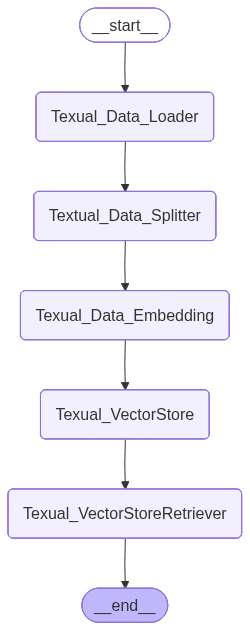

In [76]:
workflow

In [77]:
output=workflow.invoke(
    {
        "PDFFile_path":"../Input-Document/bh1.pdf",
        "query":"What is summery of the document?"
    }
)

In [79]:
output['query']

'What is summery of the document?'

In [89]:
for i in output['texual_retriever_context']:
    print(i.page_content)

limit to 1 year and file quarterly statement instead of monthly.
Ease of travel and connectivity to 
tourist destinations
Page 5
new provision for voluntary declaration of material facts post clearance and duty
‘Grameen Credit Score’ framework to serve the credit
Documentation and conservation 
of our manuscript heritage to cover
2021-22 2022-23 2023-24 2024-25
(RE)
2025-26
(BE)
17.06
18.65
20.65
22.76
25.60
15
18
21
24
27
